In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import cv2
import os
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as T

from tqdm.notebook import tqdm

seed = 42

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

In [3]:
epochs = 15
batch_size = 32
lr = 8e-5
image_size = 128
mask_size = 64
path = r'painting_model.pth'
b1 = 0.5
b2 = 0.999

patch_h, patch_w = int(mask_size / 2 ** 3), int(mask_size / 2 ** 3)
patch = (1, patch_h, patch_w)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


In [4]:
transforms = T.Compose([
    T.Resize((image_size, image_size), Image.BICUBIC),
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # to scale [-1,1] with tanh activation
])

inverse_transforms = T.Compose([
    T.Normalize(-1, 2),
    T.ToPILImage()
])

In [5]:
image_paths = sorted([str(p) for p in glob('../input/celebahq-resized-256x256/celeba_hq_256' + '/*.jpg')])

train, valid = train_test_split(image_paths, test_size=5000, shuffle=True, random_state=seed)
valid, test = train_test_split(valid, test_size=1000, shuffle=True, random_state=seed)
print(f'Train size: {len(train)}, validation size: {len(valid)}, test size: {len(test)}.')

Train size: 25000, validation size: 4000, test size: 1000.


In [7]:
class CelebaDataset(Dataset):
    def __init__(self, images_paths, transforms=transforms, train=True):
        self.images_paths = images_paths
        self.transforms = transforms
        self.train = train
        
    def __len__(self):
        return len(self.images_paths)
    
    def apply_center_mask(self, image):
        idx = (image_size - mask_size) // 2
        masked_image = image.clone()
        masked_image[:, idx:idx+mask_size, idx:idx+mask_size] = 1
        masked_part = image[:, idx:idx+mask_size, idx:idx+mask_size]
        return masked_image, idx
    
    def apply_random_mask(self, image):
        y1, x1 = np.random.randint(0, image_size-mask_size, 2)
        y2, x2 = y1 + mask_size, x1 + mask_size
        masked_part = image[:, y1:y2, x1:x2]
        masked_image = image.clone()
        masked_image[:, y1:y2, x1:x2] = 1
        return masked_image, masked_part
    
    def __getitem__(self, ix):
        path = self.images_paths[ix]
        image = Image.open(path)
        image = self.transforms(image)
        
        if self.train:
            masked_image, masked_part = self.apply_random_mask(image)
        else:
            masked_image, masked_part = self.apply_center_mask(image)
            
        return image, masked_image, masked_part
    
    def collate_fn(self, batch):
        images, masked_images, masked_parts = list(zip(*batch))
        images, masked_images, masked_parts = [[tensor[None].to(device) for tensor in ims] for ims in [images, masked_images, masked_parts]]
        images, masked_images, masked_parts = [torch.cat(ims) for ims in [images, masked_images, masked_parts]]
        return images, masked_images, masked_parts

In [8]:
train_dataset = CelebaDataset(train)
valid_dataset = CelebaDataset(valid, train=True)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=valid_dataset.collate_fn, drop_last=True)

In [11]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0, 0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1, 0.02)
        nn.init.zeros_(m.bias)
        
def set_params(model, unfreeze):
    for param in model.parameters():
        param.requires_grad = unfreeze

In [12]:
!pip install -qq torchsummary
from torchsummary import summary

In [13]:
class KLDLoss(nn.Module):
    def forward(self, mu, logvar, beta=1.0):  # beta = 0.1
        kld = -0.5 * torch.sum(1 + logvar - torch.pow(mu, 2) - torch.exp(logvar))
        return beta * kld  

# reconstruction_loss = nn.functional.binary_cross_entropy_with_logits
reconstruction_loss = nn.functional.mse_loss  # see https://stats.stackexchange.com/questions/409377/why-is-vae-reconstruction-loss-equal-to-mse-loss

kld_loss = KLDLoss()

kld_criterion = lambda x, y, mu, logvar: reconstruction_loss(y, x, reduction="sum") + kld_loss(mu, logvar, beta=0.1)  # reduction sum here + weigth for kld_loss

In [28]:
class Reshape(nn.Module):
    def __init__(self, shape=(512, 2, 2)):
        self.shape = shape
        super(Reshape, self).__init__()
        
    def forward(self, x):
        return x.view(-1, *self.shape)
    

class Generator(nn.Module):
    def __init__(self, channels=3):
        super(Generator, self).__init__()

        def downsample(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        def upsample(in_feat, out_feat, normalize=True):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers
        
        self.mean = nn.Linear(2048, 1024)
        self.std = nn.Linear(2048, 1024)

        self.encoder = nn.Sequential(
                                    *downsample(channels, 64, normalize=False),
                                    *downsample(64, 64),
                                    *downsample(64, 128),
                                    *downsample(128, 256),
                                    *downsample(256, 512),
                                    *downsample(512, 512),
                                    nn.Flatten(),
                                    nn.Linear(2048, 2048),
                                    nn.LeakyReLU(0.2)
                                    )
            
        self.decoder = nn.Sequential(
                                    nn.Linear(1024, 2048),
                                    # nn.Tanh(),  # decide whether to scale inputs
                                    Reshape(),
                                    *upsample(512, 512),
                                    *upsample(512, 256),
                                    *upsample(256, 128),
                                    *upsample(128, 64),
                                    *upsample(64, 32),
                                    nn.Conv2d(32, channels, 3, 1, 1),
                                    nn.Tanh()  # sigmoid if scale [0,1]
                                )

    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = self.mean(x), self.std(x)
        z = self.reparameterize(mu, logvar)
        y = self.decoder(z)
        
        return y, mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        sample = mu + (eps * std) 
        return sample

**Fully convolutional generator**

In [30]:
class ResDown(nn.Module):

    def __init__(self, channel_in, channel_out, scale=2):
        super(ResDown, self).__init__()
        
        self.conv1 = nn.Conv2d(channel_in, channel_out//2, 3, 1, 1)
        self.batch_norm1 = nn.BatchNorm2d(channel_out//2, 0.8)
        self.conv2 = nn.Conv2d(channel_out//2, channel_out, 3, scale, 1)
        self.batch_norm2 = nn.BatchNorm2d(channel_out, 0.8)
        
        self.conv3 = nn.Conv2d(channel_in, channel_out, 3, scale, 1)
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        skip = self.conv3(x)
        
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.activation(x + skip)
        
        return x
    
class ResUp(nn.Module):
    
    def __init__(self, channel_in, channel_out, scale=2):
        super(ResUp, self).__init__()
        
        self.conv1 = nn.Conv2d(channel_in, channel_out//2, 3, 1, 1)
        self.batch_norm1 = nn.BatchNorm2d(channel_out//2, 0.8)
        self.conv2 = nn.Conv2d(channel_out//2, channel_out, 3, 1, 1)
        self.batch_norm2 = nn.BatchNorm2d(channel_out, 0.8)
        
        self.upscale = nn.Upsample(scale_factor=scale, mode="nearest")
        self.conv3 = nn.Conv2d(channel_in, channel_out, 3, 1, 1)
        
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        skip = self.conv3(self.upscale(x))
        
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.activation(x)

        x = self.conv2(self.upscale(x))
        x = self.batch_norm2(x)

        x = self.activation(x + skip)
        
        return x

In [31]:
class Encoder(nn.Module):

    def __init__(self, channels, ch=64, z=512):
        super(Encoder, self).__init__()
        self.conv1 = ResDown(channels, ch)  
        self.conv2 = ResDown(ch, 2*ch)  
        self.conv3 = ResDown(2*ch, 4*ch)  
        self.conv4 = ResDown(4*ch, 8*ch) 
        self.conv5 = ResDown(8*ch, 8*ch)  
        self.conv_mu = nn.Conv2d(8*ch, z, 2, 2) 
        self.conv_log_var = nn.Conv2d(8*ch, z, 2, 2) 

    def sample(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        mu = self.conv_mu(x)
        log_var = self.conv_log_var(x)
        x = self.sample(mu, log_var)

        return x, mu, log_var
    
class Decoder(nn.Module):

    def __init__(self, channels, ch=64, z=512):
        super(Decoder, self).__init__()
        self.conv1 = ResUp(z, ch*8)
        self.conv2 = ResUp(ch*8, ch*4)
        self.conv3 = ResUp(ch*4, ch*2)
        self.conv4 = ResUp(ch*2, ch)
        self.conv5 = ResUp(ch, ch//2)
        self.conv6 = nn.Conv2d(ch//2, channels, 3, 1, 1)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)

        return self.activation(x) 

In [36]:
class ResnetGenerator(nn.Module):
    
    def __init__(self, channel_in=3, ch=64, z=512):
        super(ResnetGenerator, self).__init__()
        
        self.encoder = Encoder(channel_in, ch=ch, z=z)
        self.decoder = Decoder(channel_in, ch=ch, z=z)

    def forward(self, x):
        encoding, mu, log_var = self.encoder(x)
        recon = self.decoder(encoding)
        return recon, mu, log_var

In [37]:
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride, normalize, dropout, spectral):
            """Returns layers of each discriminator block"""
            if spectral:
                layers = [nn.utils.spectral_norm(nn.Conv2d(in_filters, out_filters, 3, stride, 1), n_power_iterations=2)]
            else:
                layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            if dropout:
                layers.append(nn.Dropout(p=0.5))
            return layers

        layers = []
        in_filters = channels
        for out_filters, stride, normalize, dropout, spectral in [(64, 2, False, 0, 0), (128, 2, True, 0, 0), (256, 2, True, 0, 0), (512, 1, True, 0, 0)]:
            layers.extend(discriminator_block(in_filters, out_filters, stride, normalize, dropout, spectral))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, 3, 1, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [38]:
generator = ResnetGenerator().apply(init_weights).to(device)
discriminator = Discriminator().apply(init_weights).to(device)

In [39]:
summary(generator, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
            Conv2d-2         [-1, 32, 128, 128]             896
       BatchNorm2d-3         [-1, 32, 128, 128]              64
         LeakyReLU-4         [-1, 32, 128, 128]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
         LeakyReLU-7           [-1, 64, 64, 64]               0
           ResDown-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
           Conv2d-10           [-1, 64, 64, 64]          36,928
      BatchNorm2d-11           [-1, 64, 64, 64]             128
        LeakyReLU-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,856
      BatchNorm2d-14          [-1, 128,

In [40]:
summary(discriminator, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]          73,856
    InstanceNorm2d-4          [-1, 128, 16, 16]               0
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         295,168
    InstanceNorm2d-7            [-1, 256, 8, 8]               0
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 8, 8]       1,180,160
   InstanceNorm2d-10            [-1, 512, 8, 8]               0
        LeakyReLU-11            [-1, 512, 8, 8]               0
           Conv2d-12              [-1, 1, 8, 8]           4,609
Total params: 1,555,585
Trainable params: 1,555,585
Non-trainable params: 0
---------------------------

In [42]:
adversarial_loss = nn.MSELoss()  # instead of bce loss
# pixelwise_loss = nn.L1Loss()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))  # AdamW weight_decay=1e-3, eps=1e-2
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [43]:
def train_one_batch(batch, generator, discriminator, criterion_adv, criterion_pix, optimizer_G, optimizer_D):
    generator.train()
    discriminator.train()
    
    images, masked_images, masked_parts = batch
    real = torch.FloatTensor(batch_size, *patch).fill_(1.0).requires_grad_(False).to(device)  # (1.0 - lambda)
    fake = torch.FloatTensor(batch_size, *patch).fill_(0.0).requires_grad_(False).to(device)  # (lambda)
    
    set_params(discriminator, False)
    optimizer_G.zero_grad()
    gen_parts, mu, logvar = generator(masked_images)
    
    gan_loss = criterion_adv(discriminator(gen_parts), real)
    pix_loss = criterion_pix(masked_parts, gen_parts, mu, logvar)
    
    loss_g = 0.001 * gan_loss + 0.999 * pix_loss
    loss_g.backward()
    optimizer_G.step()
    
    set_params(discriminator, True)
    optimizer_D.zero_grad()

    real_loss = criterion_adv(discriminator(masked_parts), real)
    fake_loss = criterion_adv(discriminator(gen_parts.detach()), fake)
    
    loss_d = (real_loss + fake_loss) / 2
    loss_d.backward()
    optimizer_D.step()
    
    return loss_g.item(), loss_d.item()

@torch.no_grad()
def validate_one_batch(batch, generator, discriminator, criterion_adv, criterion_pix):
    generator.eval()
    discriminator.eval()
    
    images, masked_images, masked_parts = batch
    real = torch.FloatTensor(batch_size, *patch).fill_(1.0).requires_grad_(False).to(device)
    fake = torch.FloatTensor(batch_size, *patch).fill_(0.0).requires_grad_(False).to(device)
    
    gen_parts, mu, logvar = generator(masked_images)
    
    gan_loss = criterion_adv(discriminator(gen_parts), real)  # smooth 0.1 for logloss?
    pix_loss = criterion_pix(masked_parts, gen_parts, mu, logvar)
    
    loss_g = 0.001 * gan_loss + 0.999 * pix_loss
    
    real_loss = criterion_adv(discriminator(masked_parts), real)
    fake_loss = criterion_adv(discriminator(gen_parts.detach()), fake)
    
    loss_d = (real_loss + fake_loss) / 2
    
    return loss_g.item(), loss_d.item()

@torch.no_grad()
def test_plot(test, generator, scale=1):
    idx = np.random.randint(len(test))
    random_path = test[idx]
    
    image = Image.open(random_path)
    image = transforms(image)
    
    masked_image, idx = train_dataset.apply_center_mask(image)
    
    generator.eval()
    gen_part = generator(masked_image.unsqueeze(0).to(device))[0].squeeze(0).cpu().detach()
    gen_image = masked_image.clone()
    gen_image[:, idx:idx+mask_size, idx:idx+mask_size] = gen_part
    
    # scale [-1,1] or [0,1]
    if scale:
        run_transforms = inverse_transforms
    else:
        run_transforms = T.ToPILImage()
    image = run_transforms(image)
    masked_image = run_transforms(masked_image)
    gen_image = run_transforms(gen_image)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(image)
    
    plt.subplot(132)
    plt.title('Masked Image')
    plt.imshow(masked_image)
    
    plt.subplot(133)
    plt.title('Inpainted Image')
    plt.imshow(gen_image)
    
    plt.tight_layout()
    plt.show()
    plt.pause(0.01)

Epoch 1/15


Train step 1:   0%|          | 0/781 [00:00<?, ?it/s]

Validation step 1:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/15


Train step 2:   0%|          | 0/781 [00:00<?, ?it/s]

Validation step 2:   0%|          | 0/125 [00:00<?, ?it/s]

Validation step 3:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/15


Train step 4:   0%|          | 0/781 [00:00<?, ?it/s]

Validation step 4:   0%|          | 0/125 [00:00<?, ?it/s]

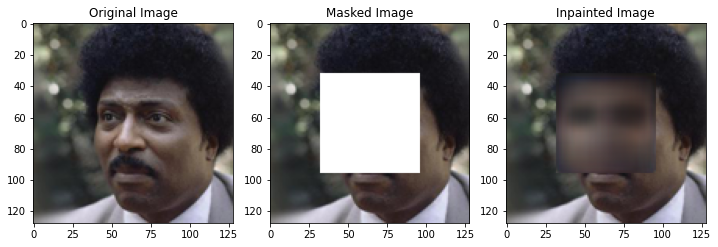

Epoch 5/15


Train step 5:   0%|          | 0/781 [00:00<?, ?it/s]

Validation step 5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 6/15


Train step 6:   0%|          | 0/781 [00:00<?, ?it/s]

Validation step 6:   0%|          | 0/125 [00:00<?, ?it/s]

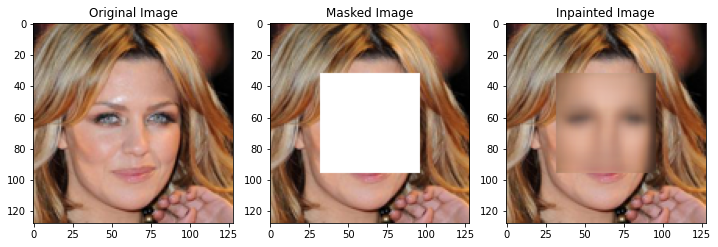

Epoch 7/15


Train step 7:   0%|          | 0/781 [00:00<?, ?it/s]

Validation step 7:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 8/15


Train step 8:   0%|          | 0/781 [00:00<?, ?it/s]

Validation step 8:   0%|          | 0/125 [00:00<?, ?it/s]

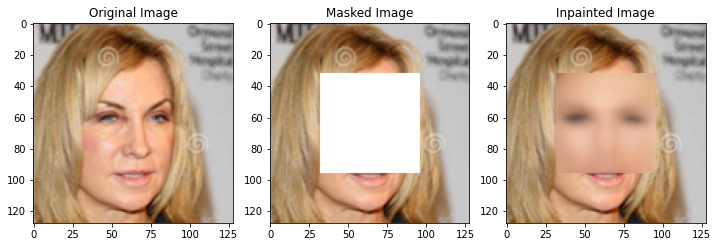

Epoch 9/15


Train step 9:   0%|          | 0/781 [00:00<?, ?it/s]

Validation step 9:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 10/15


Train step 10:   0%|          | 0/781 [00:00<?, ?it/s]

Validation step 10:   0%|          | 0/125 [00:00<?, ?it/s]

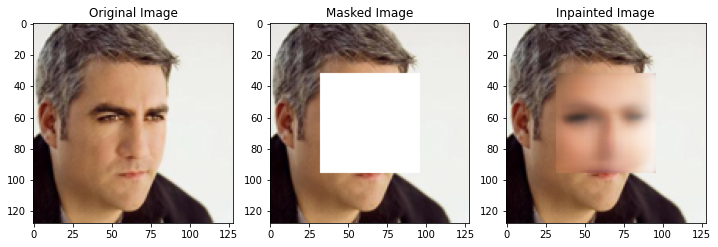

Epoch 11/15


Train step 11:   0%|          | 0/781 [00:00<?, ?it/s]

Validation step 11:   0%|          | 0/125 [00:00<?, ?it/s]

Validation step 12:   0%|          | 0/125 [00:00<?, ?it/s]

Validation step 13:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 14/15


Train step 14:   0%|          | 0/781 [00:00<?, ?it/s]

Validation step 14:   0%|          | 0/125 [00:00<?, ?it/s]

Validation step 15:   0%|          | 0/125 [00:00<?, ?it/s]

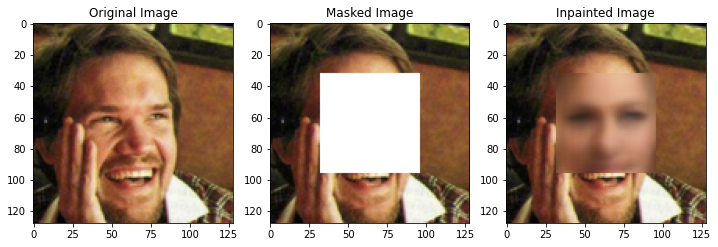

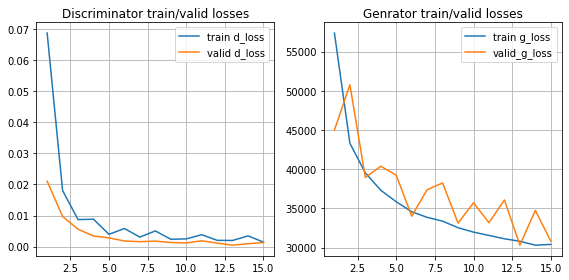

In [44]:
train_d_losses, valid_d_losses = [], []
train_g_losses, valid_g_losses = [], []

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    tq_bar = tqdm(train_dataloader, total=len(train_dataloader), desc=f'Train step {epoch+1}')
    epoch_d_losses, epoch_g_losses = [], []
    for _, batch in enumerate(tq_bar):
        g_loss, d_loss = train_one_batch(batch, generator, discriminator, adversarial_loss, 
                                         kld_criterion, optimizer_G, optimizer_D)
        epoch_g_losses.append(g_loss)
        epoch_d_losses.append(d_loss)
        tq_bar.set_postfix(g_loss=np.mean(epoch_g_losses), d_loss=np.mean(epoch_d_losses))
    train_d_losses.append(np.mean(epoch_d_losses))
    train_g_losses.append(np.mean(epoch_g_losses))
    
    tq_bar = tqdm(valid_dataloader, total=len(valid_dataloader), desc=f'Validation step {epoch+1}')
    epoch_d_losses, epoch_g_losses = [], []
    for _, batch in enumerate(tq_bar):
        g_loss, d_loss = validate_one_batch(batch, generator, discriminator, adversarial_loss, kld_criterion)
        epoch_d_losses.append(d_loss)
        epoch_g_losses.append(g_loss)
        tq_bar.set_postfix(g_loss=np.mean(epoch_g_losses), d_loss=np.mean(epoch_d_losses))
    valid_d_losses.append(np.mean(epoch_d_losses))
    valid_g_losses.append(np.mean(epoch_g_losses))
    
    if (epoch+1) % 2 == 0 or (epoch+1) == epochs:
        test_plot(test, generator)
        checkpoint = {
            'discriminator': discriminator,
            'generator': generator,
        }
        torch.save(checkpoint, path)
        
plt.figure(figsize=(8, 4))
x_axis = np.arange(1,epochs+1)
plt.subplot(121)
plt.title('Discriminator train/valid losses')
plt.plot(x_axis, train_d_losses, label='train d_loss')
plt.plot(x_axis, valid_d_losses, label='valid d_loss')
plt.grid()
plt.legend()

plt.subplot(122)
plt.title('Genrator train/valid losses')
plt.plot(x_axis, train_g_losses, label='train g_loss')
plt.plot(x_axis, valid_g_losses, label='valid_g_loss')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
@torch.no_grad()
def test1_plot(random_path, generator, scale=1):
    image = Image.open(random_path)
    image = transforms(image)
    
    masked_image, idx = train_dataset.apply_center_mask(image)
    
    generator.eval()
    gen_part = generator(masked_image.unsqueeze(0).to(device))[0].squeeze(0).cpu().detach()
    gen_image = masked_image.clone()
    gen_image[:, idx:idx+mask_size, idx:idx+mask_size] = gen_part
    
    # scale [-1,1] or [0,1]
    if scale:
        run_transforms = inverse_transforms
    else:
        run_transforms = T.ToPILImage()
    image = run_transforms(image)
    masked_image = run_transforms(masked_image)
    gen_image = run_transforms(gen_image)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(image)
    
    plt.subplot(132)
    plt.title('Masked Image')
    plt.imshow(masked_image)
    
    plt.subplot(133)
    plt.title('Inpainted Image')
    plt.imshow(gen_image)
    
    plt.tight_layout()
    plt.show()
    plt.pause(0.01)

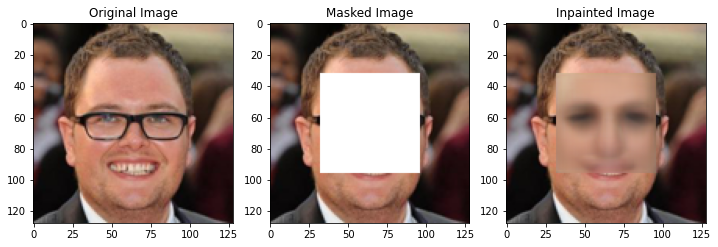

In [57]:
test_plot(test, generator)


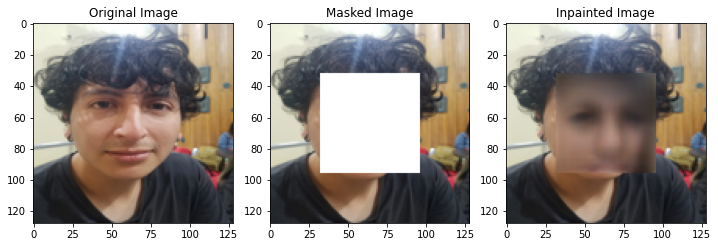

In [54]:
test1_plot('/kaggle/input/test04/test11.jpg', generator)
